In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120

In [2]:
from houghLines import HoughLines, show_lines, slope_close_to, merge_lines

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from collections import defaultdict

In [4]:
ROI_Y_RATIO = 600/2200
BINARY_THRESHOLD = 200

HOUGH_RHO_RES = 1/4
HOUGH_THETA_RES = np.pi/(4*180)
HOUGH_THRESHOLD = 300
VERTICAL_SLOPE_TOL = 15
RHO_MERGE_TOL = 10/1700

BOX_HEIGHT = 25 # needs to be a ratio (25/2200)
YGAP_BETWEEN_BOXES = 18 # needs to be a ratio (18/2200)
WRITTEN_AVG_INTENSITY_THRESH = 4

MIN_AVG_INTENSITY_SHADED_BOX = 160

In [5]:
def wreck_it(gray, theta=-0.5, scale=1.1, sigma=5):
    h,w = gray.shape
    M = cv2.getRotationMatrix2D((w/2, h/2), theta, scale)
    shifted = cv2.warpAffine(gray, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    noisy = np.clip(shifted.astype(np.uint64) + sigma*np.random.randn(h,w), a_min=0, a_max=255).astype(np.uint8)
    return noisy

In [43]:
img = cv2.imread('../test-images/c-33.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
noisy_gray = wreck_it(gray, theta=1, scale=1)

blurred = cv2.GaussianBlur(noisy_gray, (5, 5), 0)
blurred_cropped = blurred[:int(ROI_Y_RATIO*noisy_gray.shape[0]), :]
(T, threshinv) = cv2.threshold(blurred_cropped, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY_INV)
(T, threshinv_full) = cv2.threshold(blurred, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY_INV)

sobel_kernel = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]).T
pf = cv2.filter2D(src=blurred_cropped, ddepth=-1, kernel=sobel_kernel)
pf_thresh = cv2.filter2D(src=threshinv, ddepth=-1, kernel=sobel_kernel)

sobel_kernel_h = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
pf_h = cv2.filter2D(src=blurred_cropped, ddepth=-1, kernel=sobel_kernel_h)
pf_thresh_h = cv2.filter2D(src=threshinv, ddepth=-1, kernel=sobel_kernel_h)

In [44]:
%%time
lines, acc_grid, thetas, rhos = HoughLines(pf_thresh_h, 1, np.pi/(16*180), HOUGH_THRESHOLD)

diag 1803.0
CPU times: user 3.97 s, sys: 29.2 ms, total: 4 s
Wall time: 4.01 s


In [45]:
np.max(acc_grid)

941

In [46]:
rho_idxs, theta_idxs = np.nonzero(acc_grid>300)
lines = np.array(list(zip(rhos[rho_idxs], thetas[theta_idxs])))
sorted_lines = lines[np.argsort(lines[:, 0])]
vertical_lines = sorted_lines[slope_close_to(sorted_lines[:, 1], 90, tol=5)]
vertical_lines_merged = vertical_lines[merge_lines(vertical_lines, min_gap=int(RHO_MERGE_TOL*img.shape[1]))]
lines.shape, vertical_lines.shape, vertical_lines_merged.shape

((213, 2), (213, 2), (8, 2))

In [47]:
avg_theta = np.mean((180/np.pi)*vertical_lines[:,1])
avg_theta

88.86795774647888

(array([ 9.,  8., 18., 36., 26., 29., 35., 22., 13., 11.]),
 array([90.125  , 90.26875, 90.4125 , 90.55625, 90.7    , 90.84375,
        90.9875 , 91.13125, 91.275  , 91.41875, 91.5625 ]),
 <BarContainer object of 10 artists>)

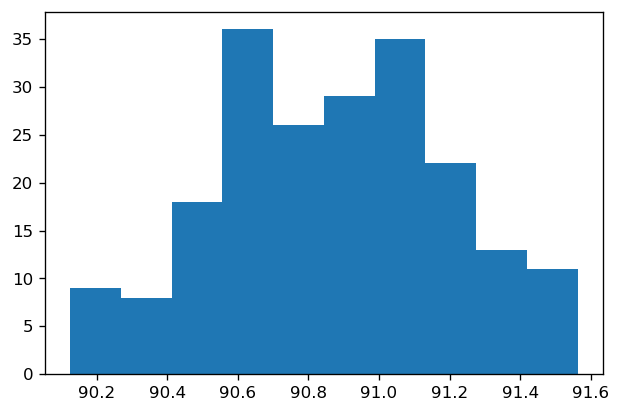

In [17]:
plt.hist((180/np.pi)*vertical_lines[:,1])

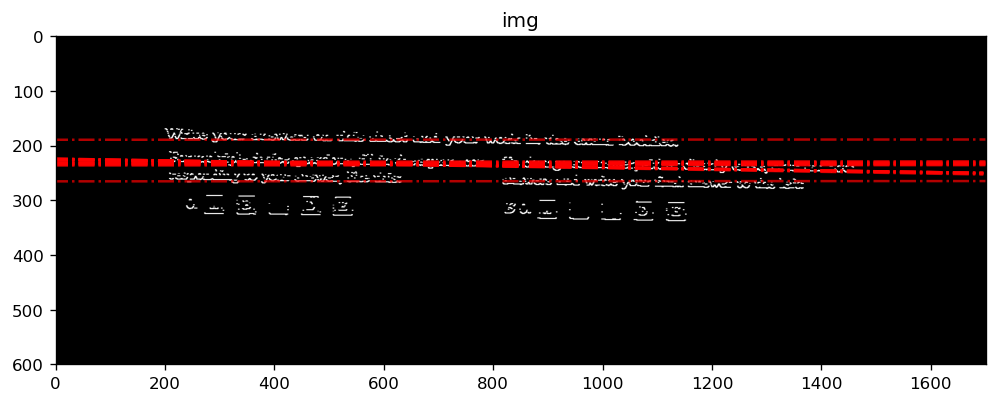

In [36]:
show_lines(pf_thresh_h, vertical_lines)

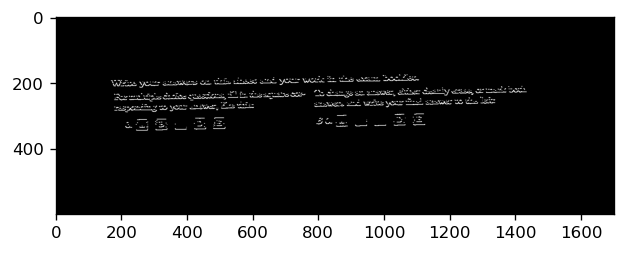

In [81]:
plt.imshow(pf_thresh_h, cmap='gray')

In [49]:
90-avg_theta

1.1320422535211208

In [ ]:
M = cv2.getRotationMatrix2D((w/2, h/2), -deviation, 1)
shifted = cv2.warpAffine(gray, M, (w, h), borderMode=cv2.BORDER_REPLICATE)

### Cleaned code

In [69]:
def preprocess_top(gray):
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    blurred_cropped = blurred[:int(ROI_Y_RATIO*gray.shape[0]), :]
    (T, threshinv) = cv2.threshold(blurred_cropped, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY_INV)

    sobel_kernel_h = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    pf_thresh_h = cv2.filter2D(src=threshinv, ddepth=-1, kernel=sobel_kernel_h)
    return pf_thresh_h

In [70]:
ROT_HOUGH_RHO_RES = 1
ROT_HOUGH_THETA_RES = np.pi/(16*180)
ROT_HOUGH_THRESHOLD = 300

def get_deviation(img):
    lines, acc_grid, thetas, rhos = HoughLines(img, ROT_HOUGH_RHO_RES, ROT_HOUGH_THETA_RES, ROT_HOUGH_THRESHOLD)
    sorted_lines = lines[np.argsort(lines[:, 0])]
    horizontal_lines = sorted_lines[slope_close_to(sorted_lines[:, 1], 90, tol=VERTICAL_SLOPE_TOL)]
    return 90-np.mean((180/np.pi)*horizontal_lines[:, 1])

In [65]:
def rotate(gray, theta):
    h,w = gray.shape
    M = cv2.getRotationMatrix2D((w/2, h/2), theta, 1)
    shifted = cv2.warpAffine(gray, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    return shifted

In [67]:
def correct_tilt(gray):
    img_pr = preprocess_top(gray)
    deviation = get_deviation(img_pr)
    print('detected deviation:', deviation)

    gray_rot = rotate(gray, -deviation)
    return gray_rot

In [71]:
img = cv2.imread('../test-images/c-33.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
noisy_gray = wreck_it(gray, theta=-2, scale=1)

gray_rot=correct_tilt(noisy_gray)

img_pr = preprocess_top(gray_rot)
deviation = get_deviation(img_pr)
print('detected deviation:', deviation)

diag 1803.0
detected deviation -1.8642441860465055
diag 1803.0
detected deviation: 0.009900990099012574


### Test on extracting vertical patches from rotated images

In [6]:
import grade2

In [7]:
img = cv2.imread('../test-images/c-33.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
noisy_gray = wreck_it(gray, theta=-2, scale=1)

##### without correcting tilt

In [8]:
img_processed = grade2.preprocess(noisy_gray)
vlines = grade2.get_vertical_lines(img_processed)

diag 2335.0


In [9]:
vlines.shape

(6, 2)

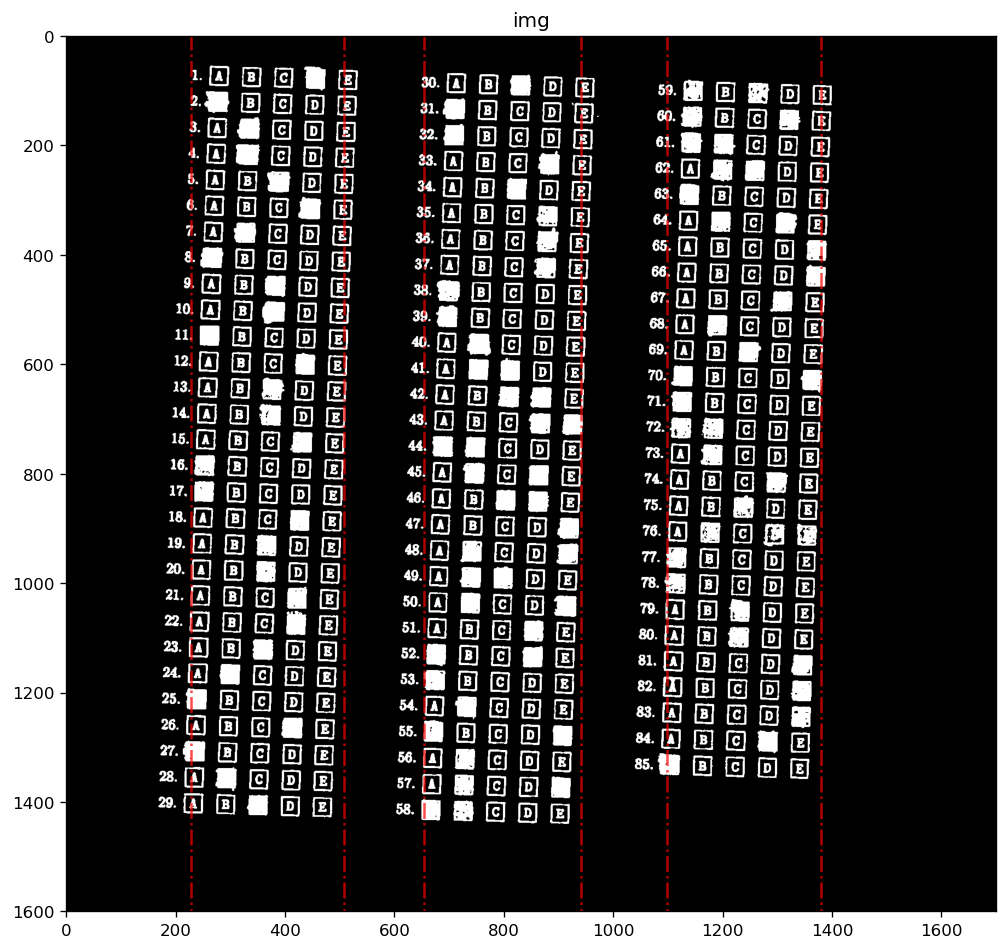

In [10]:
show_lines(img_processed, vlines)

##### with tilt correction

In [12]:
gray_rot=grade2.correct_tilt(noisy_gray)
img_processed = grade2.preprocess(gray_rot)
vlines = grade2.get_vertical_lines(img_processed)

diag 1803.0
detected deviation: -1.8708920187793439
diag 2335.0


In [13]:
vlines.shape

(36, 2)

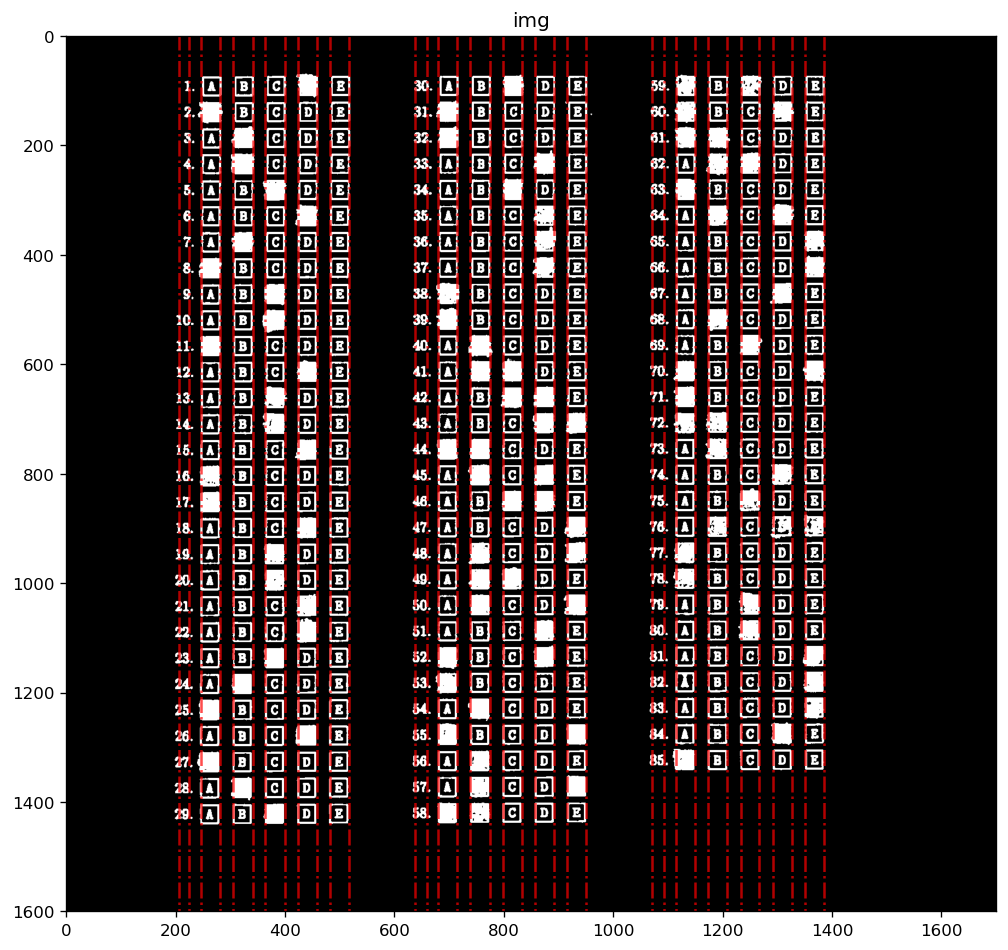

In [14]:
show_lines(img_processed, vlines)

### Custom rotate implementation

https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#gafbbc470ce83812914a70abfb604f4326

In [ ]:
def rotate_custom(theta, scale, center):

    alpha = scale * np.cos(theta)
    beta = scale * np.sin(theta)
    x,y = center

    M = np.array([[alpha, beta, (1-alpha)*x - beta*y], 
                  [-beta, alpha beta*x + (1-alpha)*y]])
